In [3]:
import json
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os
from tqdm import tqdm
import openai
import time

start_time = time.time()

PATH = "./regenerated/results_reddit_gpt2.json"
METHOD = "Edit Distance"
DATA = "GPT2"

# Prepare OpenAI parameters
openai.api_key = "API_KEY"
os.environ['AZURE_OPENAI_ENDPOINT'] = "API_ENDPOINT"
openai.api_type = "azure"
openai.api_version = "API_DATE"

print("Loading Data...")
#! Load Data from file
data = None
with open(PATH, "r") as f:
    data = json.load(f)
print(f"{len(data)} generated texts loaded.")

Loading Data...
360 generated texts loaded.


In [4]:
from nltk.stem.porter import PorterStemmer
from utils import tokenize

def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

human_scores = []
ai_scores = []

for idx in tqdm(range(len(data))):
    # tokenization
    cur = data[idx]
    masked_original = cur["masked_original"]
    human_tokenized = tokenize(masked_original, stemmer=PorterStemmer())
    generated = cur["masked_generated"]
    if generated == None or len(generated) == 0: continue

    # going through each generation
    total = 0
    total_cnt = 0
    for j in range(len(generated)):
        generated_tokenized = tokenize(generated[j], stemmer=PorterStemmer())
        if len(human_tokenized) == 0 or len(generated_tokenized) == 0:
            continue
        else:
            total_cnt += 1
        total += levenshteinDistance(generated_tokenized, human_tokenized)
    
    if total_cnt == 0: continue
    if cur["type"] == "ai":
        ai_scores.append(total / total_cnt)
    else:
        human_scores.append(total / total_cnt)


100%|██████████| 360/360 [03:42<00:00,  1.62it/s]


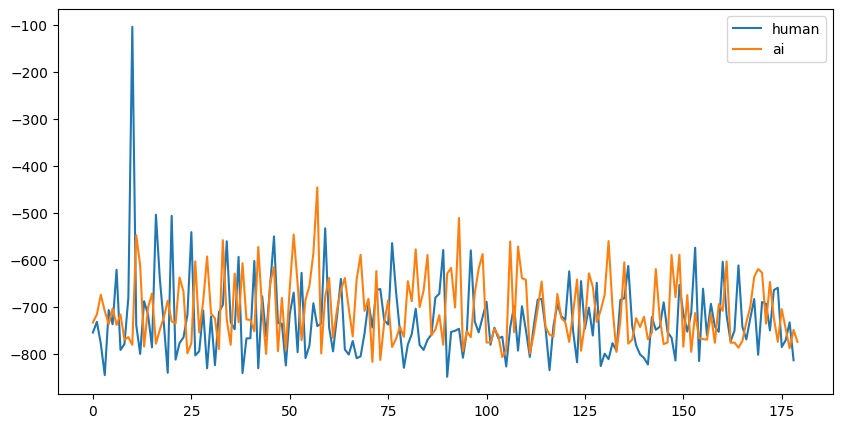

In [5]:
# Flip it
human_scores = [-human_score for human_score in human_scores]
ai_scores = [-ai_score for ai_score in ai_scores]

#! Plot Results
plt.figure(figsize=(10, 5))
plt.plot(human_scores, label='human')
plt.plot(ai_scores, label='ai')
plt.legend()
plt.show()

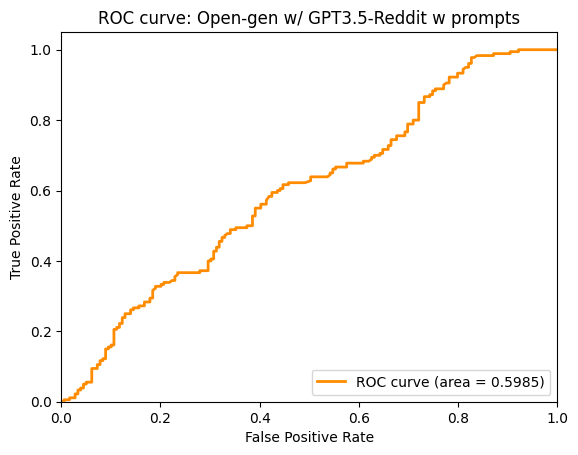

TPR at 1% FPR: 0.5182122905027935


In [10]:
#! ROC Curve Plotting
def plot_roc_curve(human_scores, gpt_scores):
    # Data
    A = human_scores
    B = gpt_scores
    # Combine scores and true labels
    scores = A + B
    labels = [0] * len(A) + [1] * len(B)
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, scores)
    # Calculate AUC (Area Under Curve)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: Open-gen w/ GPT3.5-Reddit w prompts' )
    plt.legend(loc="lower right")
    plt.show()

    # find the closest fpr more than 1% fpr
    fpr_setting = 0.40
    coords1 = (0, 0)
    for idx, fpr_ in enumerate(fpr):
        if fpr_ > fpr_setting:
            coords1 = (float(fpr[idx]), float(tpr[idx]))
            break
    
    coords2 = (0, 0)
    for idx, fpr_ in enumerate(reversed(fpr)):
        if fpr_ < fpr_setting:
            coords2 = (float(fpr[len(fpr) - idx - 1]), float(fpr[len(fpr) - idx - 1]))
            break

    # (x1, y1) and (x2, y2)
    # Gradient = (y2 - y1) / (x2 - x1)
    # y = [(y2 - y1) / (x2 - x1)] (0.01 - x2) + y2
    tpr_at_one_fpr = ((coords2[1] - coords1[1]) / (coords2[0] - coords1[0])) * (fpr_setting - coords2[0]) + coords2[1]
    print(f"TPR at 1% FPR: {tpr_at_one_fpr}")

plot_roc_curve(human_scores, ai_scores)

In [7]:
# Save Results
import json

if not os.path.exists(f"./results/{DATA}"):
    os.makedirs(f"./results/{DATA}")

with open(f"./results/{DATA}/{METHOD}.json", "w+") as f:
	json.dump({"ai_scores": ai_scores, "human_scores": human_scores, "time": time.time() - start_time}, f)